In [39]:
import torch
import torch.nn.functional as F
import random
import math
import time
import matplotlib.pyplot as plt

### building data

In [40]:
all_words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(all_words))))
ctoi = {c:i+1 for i, c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:c for c, i in ctoi.items()}

CONTEXT_WINDOW =4

def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * CONTEXT_WINDOW
        #print(w)
        for ch in w + '.':
            ix = ctoi[ch]
            Y.append(ix)
            X.append(context)
            #print(''.join(itoc[po] for po in context), '--->', ch)
            context = context[1:] + [ix]
            
    return (X, Y)

random.shuffle(all_words)

L1 = int(0.8*len(all_words))
L2 = L1 + int(0.1*len(all_words))

X_train, Y_train = build_dataset(all_words[:L1])
X_val, Y_val = build_dataset(all_words[L1:L2])
X_test, Y_test = build_dataset(all_words[L2:])

X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)
X_val = torch.tensor(X_val)
Y_val = torch.tensor(Y_val)
X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test)

In [41]:

class Linear:
    
    def __init__ (self, fanin, fanout, bias=True):
        self.W = torch.randn((fanin, fanout)) * ((2/fanin) ** 0.5)
        self.b = torch.zeros(fanout) + .01 if bias else None
        self.bias = bias
        
    def __call__(self, X):
        self.out = X @ self.W
        if self.bias is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W] + [self.b if self.bias else None]
    
    
class ReLU:
    
    def __call__(self, X):
        self.out = torch.relu(X)
        return self.out
    
    def parameters(self):
        return []

class BatchNorm1D:
    
    def __init__(self, dim, momentum=.1, eps=1e-5):
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.training = True
        
        self.momentum = momentum
        self.eps = eps ** 0.5
        
        self.running_std = torch.zeros(1)
        self.running_mean = torch.zeros(1)
    
    def parameters(self):
        return [self.gamma] + [self.beta]
        
    def __call__(self, X):
        if self.training:
            mean = X.mean(0, keepdim=True)
            std = X.std(0, keepdim=True)
            with torch.no_grad():
                self.running_std = (1-self.momentum) * self.running_std + self.momentum * std
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * mean
        else:
            mean = self.running_mean
            std = self.running_std
        self.out = self.gamma * ((X-mean) / std + self.eps) + self.beta
        return self.out
    

In [52]:
CONTEXT = 4
WORDVEC = 15
NIN = CONTEXT * WORDVEC
HIDDEN = 200

C = torch.randn(27, WORDVEC) #character embeddings
model = [
    Linear(NIN, HIDDEN), BatchNorm1D(HIDDEN), ReLU(),
    Linear(HIDDEN, HIDDEN), BatchNorm1D(HIDDEN), ReLU(),
    Linear(HIDDEN, HIDDEN), BatchNorm1D(HIDDEN), ReLU(),
    Linear(HIDDEN, HIDDEN), BatchNorm1D(HIDDEN), ReLU(),
    Linear(HIDDEN, 27)
]

parameters = [C] + [p for layer in model for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True
    
ud = []

### training

In [53]:
ITERATIONS = 200000
BATCH_SIZE = 32
train_losses = []
train_steps = []
val_losses = []
val_steps = []

for i in range(ITERATIONS):
    ix = torch.randint(0, X_train.shape[0], (BATCH_SIZE, ))
    enc = C[X_train[ix]].view(BATCH_SIZE, -1)
    
    pred = enc
    for layer in model:
        pred = layer(pred)
        
    loss = F.cross_entropy(pred, Y_train[ix])
    
    for layer in model:
        layer.out.retain_grad()
        
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = .05 if ITERATIONS < 100000 else .01
    for p in parameters:
        p.data += -lr * p.grad
        
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i % 20000 == 0:
        print(f'ROUND: {i}/{ITERATIONS} loss: {loss.item()}')
    

ROUND: 0/200000 loss: 3.608053207397461
ROUND: 20000/200000 loss: 2.0393178462982178
ROUND: 40000/200000 loss: 1.8297556638717651
ROUND: 60000/200000 loss: 1.9464693069458008
ROUND: 80000/200000 loss: 1.8208229541778564
ROUND: 100000/200000 loss: 2.082033395767212
ROUND: 120000/200000 loss: 2.097797155380249
ROUND: 140000/200000 loss: 1.7754263877868652
ROUND: 160000/200000 loss: 1.626232385635376
ROUND: 180000/200000 loss: 1.9840775728225708


In [56]:
emb = C[X_test]
pred = emb.view(emb.shape[0], -1)
for layer in model:
    pred = layer(pred)

F.cross_entropy(pred, Y_test)

tensor(2.0059, grad_fn=<NllLossBackward0>)

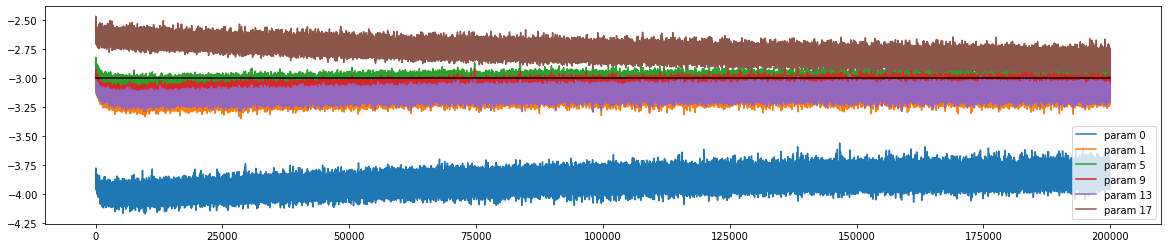

In [55]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

layer 2 (      ReLU): mean +0.42, std 0.55, saturated: 45.59%
layer 5 (      ReLU): mean +0.41, std 0.56, saturated: 47.22%
layer 8 (      ReLU): mean +0.40, std 0.57, saturated: 49.84%
layer 11 (      ReLU): mean +0.39, std 0.60, saturated: 54.41%


Text(0.5, 1.0, 'activation distribution')

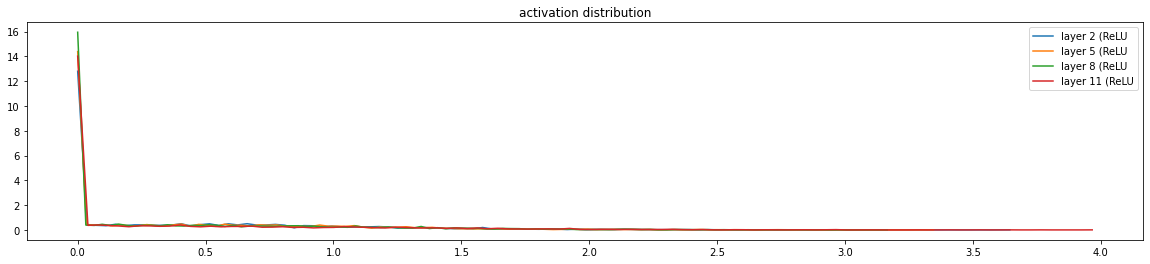

In [44]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model[:-1]): # note: exclude the output layer
  if isinstance(layer, ReLU):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() <= 0).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      ReLU): mean -0.000000, std 5.284682e-03
layer 5 (      ReLU): mean +0.000000, std 4.443830e-03
layer 8 (      ReLU): mean -0.000000, std 3.820459e-03
layer 11 (      ReLU): mean +0.000010, std 3.771793e-03


Text(0.5, 1.0, 'gradient distribution')

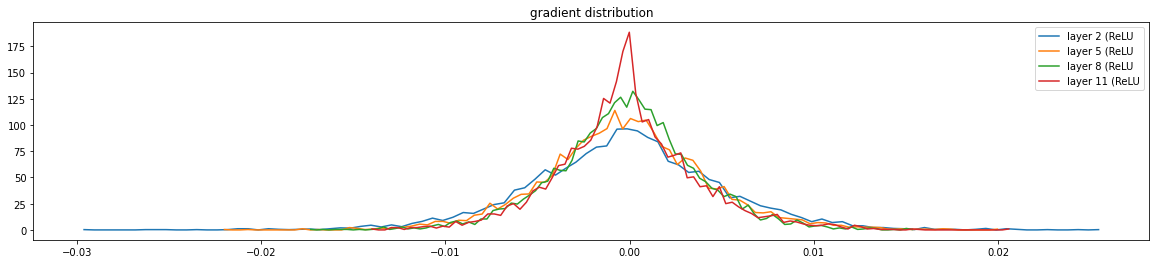

In [45]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model[:-1]): # note: exclude the output layer
  if isinstance(layer, ReLU):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')